In [15]:
%matplotlib inline

import pandas as pd
import numpy as np

from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'

In [2]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                   index_col=0, parse_dates=True).dropna()

In [5]:
data = pd.DataFrame(raw['EUR='])
data.rename(columns={'EUR=': 'price'}, inplace=True)

SMA: 単純移動平均
4.2では長期移動平均と短期移動平均をつかったシグナルを作成
Rule: SMA1 > SMA2 go long, else short

In [8]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

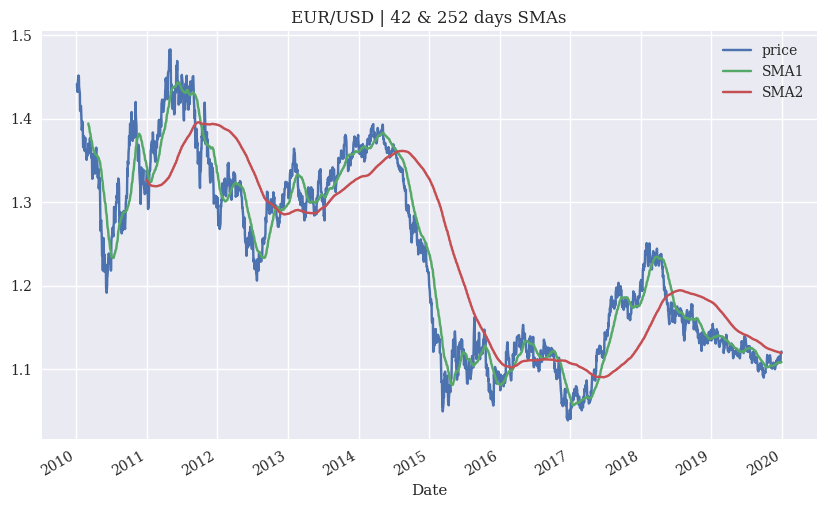

In [13]:
data.plot(title='EUR/USD | 42 & 252 days SMAs',
          figsize=(10, 6));

In [18]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data.dropna(inplace=True)

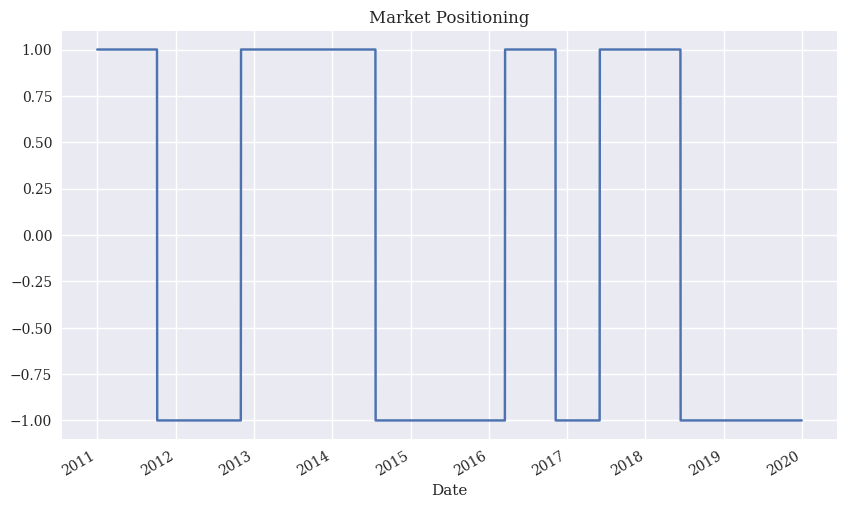

In [20]:
data['position'].plot(ylim=[-1.1, 1.1],
                      title='Market Positioning',
                      figsize=(10, 6));

### Terminology
対数収益率 利点
時間加重平均: 複数期間にわたる収益率を簡単に加算することができます。これは、対数収益率が時間に対して加重されるため、長期間にわたる投資のパフォーマンスを評価する際に便利です。
再投資の仮定: 対数収益率は、収益が自動的に再投資されるという仮定の下で計算されます。これにより、複利効果を考慮したより現実に近い収益の測定が可能になります。
対称性: 資産価格が同じ割合で上昇した場合と下降した場合の収益率が対称的になります。たとえば、価格が10%上昇した後に10%下落すると、全体としては損失が発生しますが、対数収益率ではこの対称性が保たれます。

In [28]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data['strategy'] = data['position'].shift(1) * data['returns']

In [30]:
# Compare log return of strategy vs the benchmark
data[['returns', 'strategy']].sum() # log return

returns    -0.176731
strategy    0.253121
dtype: float64

In [31]:
# Compare return of strategy vs the benchmark
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

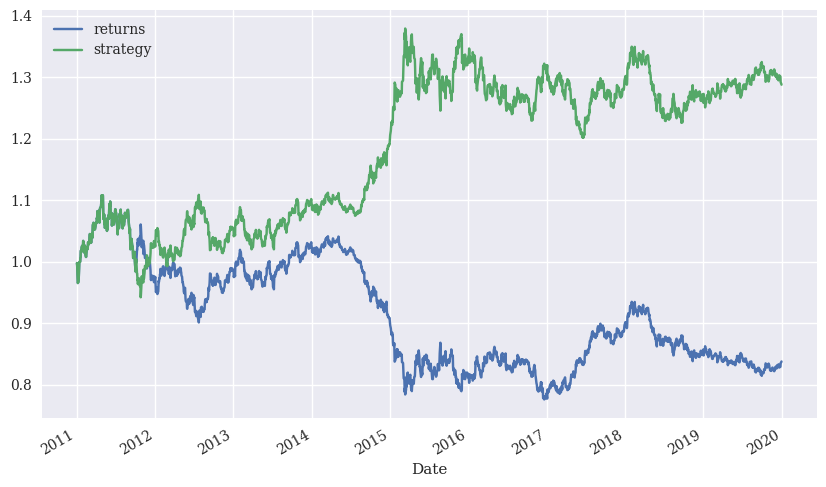

In [32]:
# Chart two strategy
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

In [33]:
# Risk return (yearly)
data[['returns', 'strategy']].mean() * 252 # log return
np.exp(data[['returns', 'strategy']].mean() * 252) - 1

returns    -0.019479
strategy    0.028575
dtype: float64

In [34]:
# yearly std 
data[['returns', 'strategy']].std() * 252 ** 0.5 #log
(data[['returns', 'strategy']].apply(np.exp) - 1).std() * 252 ** 0.5


returns     0.085405
strategy    0.085373
dtype: float64

最大ドローダウン（Maximum Drawdown, MDD）は、投資のパフォーマンスを評価する際に使用される指標の一つで、特定の期間における資産価値の最大の減少幅を示します。これは、投資ポートフォリオが経験する可能性のある最大のリスクを表し、リスク管理や投資戦略の評価において重要な役割を果たします。

最大ドローダウンは、ピーク（最高値）からトラフ（その後の最低値）までの価値の減少率で計算されます。数式で表すと、次のようになります：

$$ 最大ドローダウン (MDD) = \frac{\text{ピークからトラフまでの減少額}}{\text{ピークの価値}} \times 100\% $$ 

この指標は、投資家が市場の不確実性や価格変動にどれだけ耐えられるか、またその投資がどれだけのリスクを伴うかを理解するのに役立ちます。最大ドローダウンが大きいほど、投資はより高いリスクを伴うと考えられ、投資家はそれだけ大きな損失に直面する可能性があります。

In [35]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp) # gross performance
data['cummax'] = data['cumret'].cummax() # max of gross performance

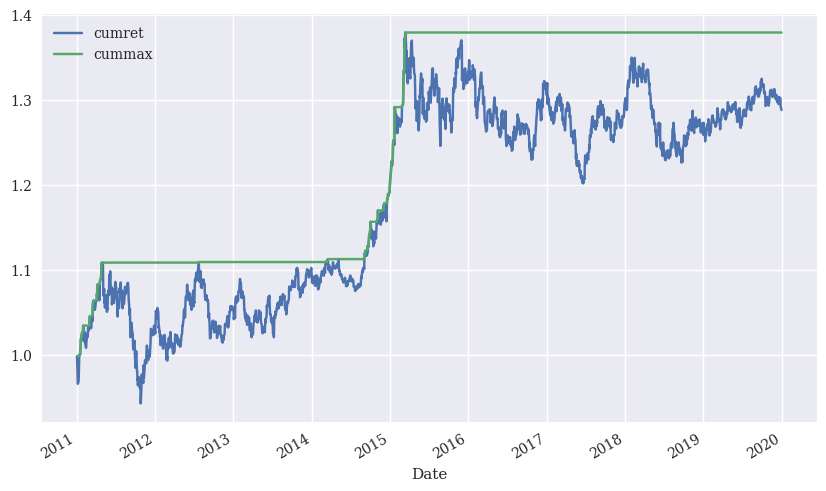

In [37]:
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6));

In [38]:
drawdown = data['cummax'] - data['cumret']

In [39]:
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [40]:
periods.max()

datetime.timedelta(days=596)

Check class SMAVectorBacktester(object): for generalization approach
## Strategies based on Momentum

In [41]:
data = pd.DataFrame(raw['XAU='])
data.rename(columns={'XAU=': 'price'}, inplace=True)
data['returns'] = np.log(data['price'] / data['price'].shift(1))

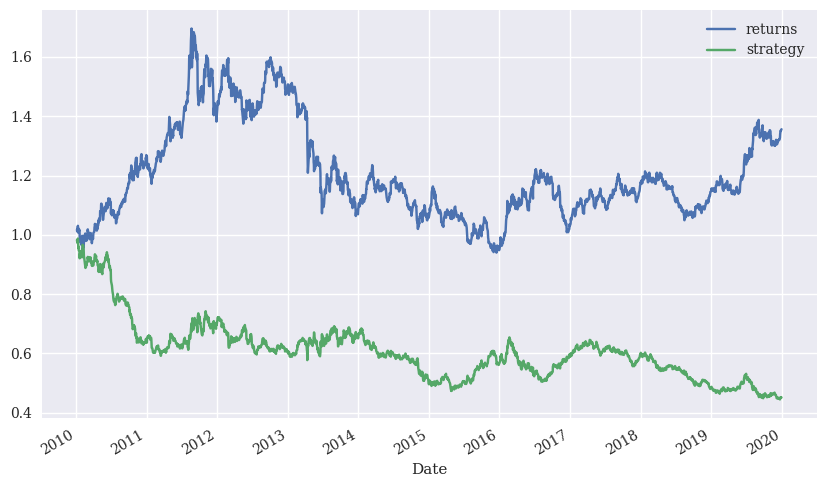

In [42]:
data['position'] = np.sign(data['returns']) # 直近のリターンの符号
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6)); # benchmarkにタコ負け

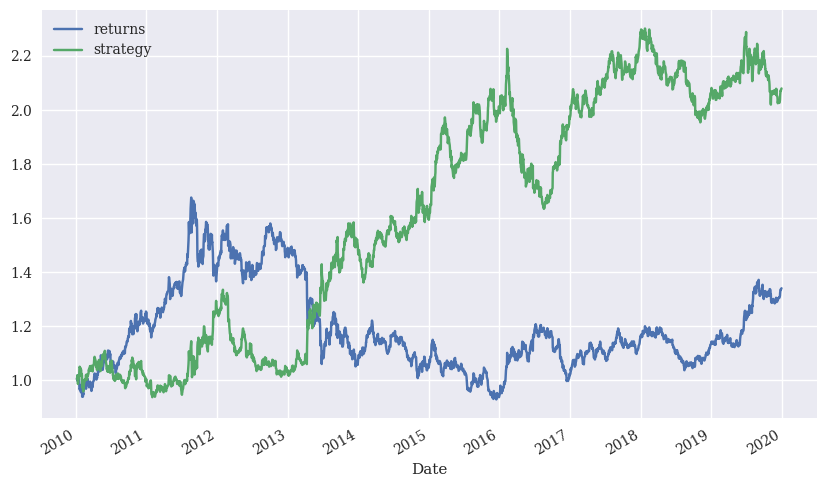

In [43]:
# improvise by having longer period return
data['position'] = np.sign(data['returns'].rolling(3).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6)); # take note that this is very dependent on rolling parameter...

#### Intraday Data from Eikon

In [47]:
fn = '../data/AAPL_1min_05052020.csv'
# fn = '../data/SPX_1min_05052020.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True)

In [49]:
data['returns'] = np.log(data['CLOSE'] /
                         data['CLOSE'].shift(1))
to_plot = ['returns']

In [50]:
for m in [1, 3, 5, 7, 9]:
    data['position_%d' % m] = np.sign(data['returns'].rolling(m).mean())
    data['strategy_%d' % m] = (data['position_%d' % m].shift(1) *
                               data['returns'])
    to_plot.append('strategy_%d' % m) 

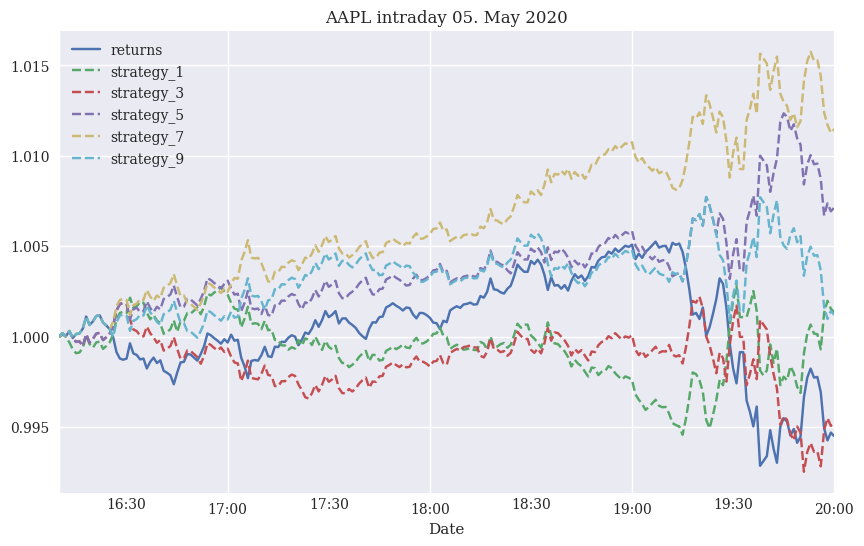

In [51]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='AAPL intraday 05. May 2020',
    figsize=(10, 6), style=['-', '--', '--', '--', '--', '--']);

### Generalizing the Approach
check class MomVectorBacktester(object):

## Strategies based on Mean-Reversion
価格や収益率が長期的な平均（または正常値）に向かって戻る傾向に基づいています。この戦略は、「極端な価格変動は一時的であり、時間が経つにつれて平均に戻る」という原理に基づく

In [52]:
data = pd.DataFrame(raw['GDX'])
data.rename(columns={'GDX': 'price'}, inplace=True)
data['returns'] = np.log(data['price'] /
                         data['price'].shift(1))

In [53]:
SMA = 25
threshold = 3.5

In [54]:
data['SMA'] = data['price'].rolling(SMA).mean()
data['distance'] = data['price'] - data['SMA']

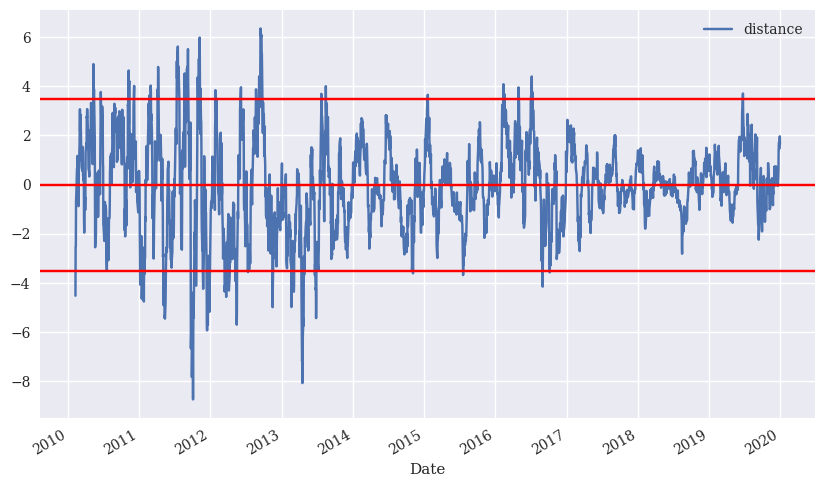

In [55]:
data['distance'].dropna().plot(figsize=(10, 6), legend=True)
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r');

In [56]:
data['position'] = np.where(data['distance'] > threshold,
                            -1, np.nan)
data['position'] = np.where(data['distance'] < -threshold,
                            1, data['position'])
data['position'] = np.where(data['distance'] *
            data['distance'].shift(1) < 0, 0, data['position'])
data['position'] = data['position'].ffill().fillna(0)

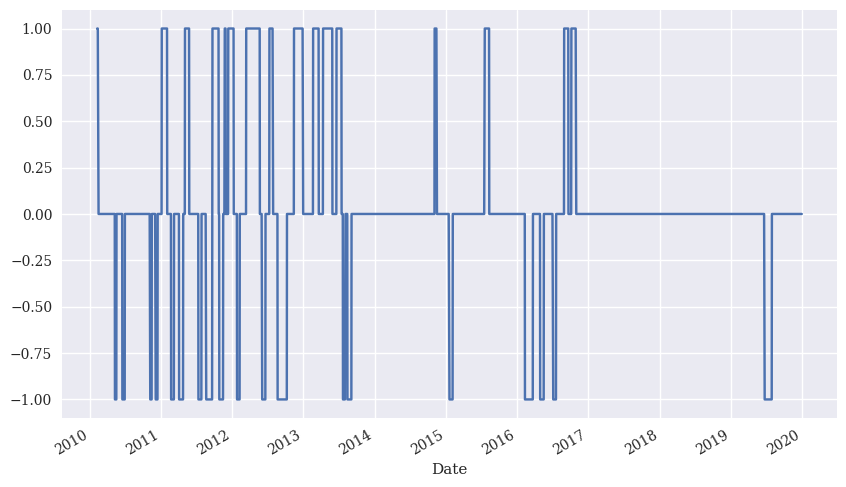

In [57]:
data['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],
                               figsize=(10, 6));

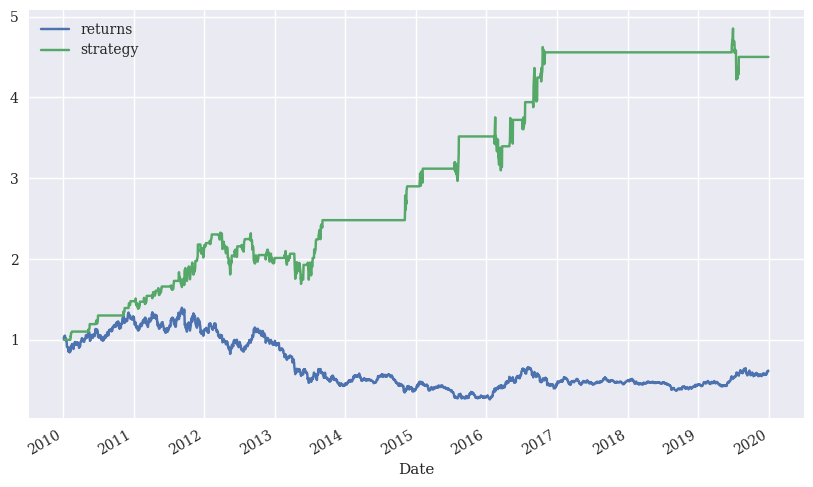

In [58]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

### Generalizing the Approach 
check class MRVectorBacktester(MomVectorBacktester):